In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

import kagglehub


path = kagglehub.dataset_download("wesleyjwu123/nintendo-midis")

In [4]:
!pip install music21 torch pretty_midi tqdm --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 47.3 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 4.1 MB/s eta 0:00:00


In [5]:
# 📚 2. Import libraries
import os
import music21
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pretty_midi
import pickle
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import random
from tqdm import tqdm

In [6]:
# 🔍 3. Recursively preprocess a subset of Nintendo MIDI files
midi_dir = Path("/kaggle/input/nintendo-midis/Nintendo")
chord_vocab, melody_vocab = {}, {}
chord_seqs, melody_seqs = [], []

max_len = 64  # Increased length for longer melodies
max_files = 1000  # Limit to avoid timeout
midi_files = list(midi_dir.rglob("*.mid"))
random.shuffle(midi_files)


def note_to_int(note):
    return int(note.pitch.midi)

def chord_to_label(chord):
    root = chord.root().name
    quality = chord.quality
    return f"{root}_{quality}"

for file in tqdm(midi_files[:max_files], desc="Processing MIDI files"):
    try:
        score = music21.converter.parse(file)
        if isinstance(score, music21.stream.Opus):
            if len(score.scores) == 0:
                continue
            score = score.scores[0]

        chords = score.chordify().flatten().getElementsByClass('Chord')
        melody = score.parts[0].flatten().getElementsByClass('Note')

        chord_seq = []
        for c in chords[:max_len]:
            label = chord_to_label(c)
            if label not in chord_vocab:
                chord_vocab[label] = len(chord_vocab)
            chord_seq.append(chord_vocab[label])

        melody_seq = []
        for n in melody[:max_len]:
            midi = note_to_int(n)
            if midi not in melody_vocab:
                melody_vocab[midi] = len(melody_vocab)
            melody_seq.append(melody_vocab[midi])

        if len(chord_seq) == len(melody_seq) == max_len:
            chord_seqs.append(chord_seq)
            melody_seqs.append(melody_seq)
    except Exception as e:
        print(f"Failed on {file}: {e}")

with open("processed.pkl", "wb") as f:
    pickle.dump({
        "chord_seqs": chord_seqs,
        "melody_seqs": melody_seqs,
        "chord_vocab": chord_vocab,
        "melody_vocab": melody_vocab
    }, f)

print(f"✅ Saved {len(chord_seqs)} Nintendo MIDI sequences.")

Processing MIDI files: 100%|██████████| 1000/1000 [22:09<00:00,  1.33s/it] 

✅ Saved 842 Nintendo MIDI sequences.


In [7]:
# 🧠 4. Define dataset and LSTM model
class ChordMelodyDataset(Dataset):
    def __init__(self, X, Y, seq_len):
        self.X = X
        self.Y = Y
        self.seq_len = seq_len

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.X[idx][:self.seq_len]),
            torch.tensor(self.Y[idx][:self.seq_len])
        )

class ChordToMelodyLSTM(nn.Module):
    def __init__(self, chord_vocab, melody_vocab, hidden_dim=128):
        super().__init__()
        self.chord_embed = nn.Embedding(chord_vocab, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
        self.attn = nn.MultiheadAttention(embed_dim=hidden_dim*2, num_heads=2, batch_first=True)
        self.out = nn.Sequential(
            nn.Linear(hidden_dim*2, hidden_dim*2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim*2, melody_vocab)
        )

    def forward(self, chords):
        x = self.chord_embed(chords)
        h, _ = self.lstm(x)
        attn_output, _ = self.attn(h, h, h)
        return self.out(attn_output)

In [8]:
# 🚀 5. Train model
with open("processed.pkl", "rb") as f:
    data = pickle.load(f)

chord_seqs = data["chord_seqs"]
melody_seqs = data["melody_seqs"]
chord_vocab_size = len(data["chord_vocab"])
melody_vocab_size = len(data["melody_vocab"])

seq_len = 64  # Match new max_len
# Filter out sequences that don't match the required seq_len
filtered_pairs = [
    (c, m) for c, m in zip(chord_seqs, melody_seqs)
    if len(c) == seq_len and len(m) == seq_len
]
print(len(filtered_pairs))
chord_seqs, melody_seqs = zip(*filtered_pairs) if filtered_pairs else ([], [])

dataset = ChordMelodyDataset(chord_seqs, melody_seqs, seq_len)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

model = ChordToMelodyLSTM(chord_vocab_size, melody_vocab_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(200):
    total_loss = 0
    for chords, melody in loader:
        logits = model(chords)
        loss = criterion(logits.view(-1, melody_vocab_size), melody.view(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch}: Loss = {total_loss:.4f}")

torch.save(model.state_dict(), "lstm_model.pt")
print("✅ Model saved!")

842
Epoch 0: Loss = 111.2651
Epoch 1: Loss = 105.0371
Epoch 2: Loss = 102.5017
Epoch 3: Loss = 101.3788
Epoch 4: Loss = 100.3067
Epoch 5: Loss = 99.7676
Epoch 6: Loss = 98.8341
Epoch 7: Loss = 98.2670
Epoch 8: Loss = 97.6297
Epoch 9: Loss = 96.9168
Epoch 10: Loss = 96.2379
Epoch 11: Loss = 95.5765
Epoch 12: Loss = 94.5523
Epoch 13: Loss = 93.8198
Epoch 14: Loss = 93.0864
Epoch 15: Loss = 91.8869
Epoch 16: Loss = 90.7931
Epoch 17: Loss = 89.3909
Epoch 18: Loss = 88.2020
Epoch 19: Loss = 87.1476
Epoch 20: Loss = 86.1893
Epoch 21: Loss = 84.3034
Epoch 22: Loss = 83.0780
Epoch 23: Loss = 82.1959
Epoch 24: Loss = 81.0985
Epoch 25: Loss = 79.3553
Epoch 26: Loss = 78.7193
Epoch 27: Loss = 77.5775
Epoch 28: Loss = 76.7018
Epoch 29: Loss = 75.8736
Epoch 30: Loss = 74.8715
Epoch 31: Loss = 74.4977
Epoch 32: Loss = 73.4745
Epoch 33: Loss = 73.0605
Epoch 34: Loss = 72.8550
Epoch 35: Loss = 72.0819
Epoch 36: Loss = 71.8827
Epoch 37: Loss = 70.9003
Epoch 38: Loss = 70.3354
Epoch 39: Loss = 69.7457
E

In [9]:
def generate_midi(melody_ids, melody_vocab, filename="generated.mid"):
    inv_vocab = {v: k for k, v in melody_vocab.items()}
    pm = pretty_midi.PrettyMIDI()
    inst = pretty_midi.Instrument(program=0)
    for i, idx in enumerate(melody_ids):
        pitch = inv_vocab.get(idx, 60)
        note = pretty_midi.Note(
            velocity=100, pitch=pitch, start=i*0.5, end=(i+1)*0.5
        )
        inst.notes.append(note)
    pm.instruments.append(inst)
    pm.write(filename)

In [45]:
# 🎼 7. Generate new melody from custom chord input

def sample_logits(logits, temperature=1.0):
    probs = torch.softmax(logits / temperature, dim=-1)
    return torch.multinomial(probs, num_samples=1)

def generate_from_model(model, chord_sequence, melody_vocab, device="cpu", temperature=1.0):
    model.eval()
    with torch.no_grad():
        chords = torch.tensor(chord_sequence).unsqueeze(0).to(device)
        logits = model(chords).squeeze(0)
        sampled = [sample_logits(logits[i], temperature).item() for i in range(logits.size(0))]
        return sampled

# ✅ Load model for inference
model.load_state_dict(torch.load("lstm_model.pt"))
model.eval()

# # 🆕 Example: generate a longer melody from a longer chord progression
# nintendo_intro = [data["chord_vocab"].get(label) for label in [
#     "C_major", "A_minor", "F_major", "G_major",
#     "E_minor", "D_minor", "C_major", "A_minor",
#     "F_major", "G_major", "C_major", "A_minor",
#     "F_major", "G_major", "E_minor", "D_minor",
# ]]

# nintendo_intro = [data["chord_vocab"].get(label) for label in [
#     "C_major", "F_major", "G_major", "C_major"
# ]]
nintendo_intro = [data["chord_vocab"].get(label) for label in [
    "C_major",   # I
    "E_major",   # III (borrowed from C Lydian / chromatic mediant)
    "A_minor",   # vi (relative minor)
    "F_major"    # IV – sets up a nice loop back to I or V
]]


nintendo_intro = [c if c is not None else 0 for c in nintendo_intro] + [0] * (64 - 16)

generated_ids = generate_from_model(model, nintendo_intro, data["melody_vocab"], temperature=0.8)
generate_midi(generated_ids, data["melody_vocab"], "generate_new.mid")

In [11]:
#EVALUATION 
!pip install muspy
import torch, muspy, music21 as m21, numpy as np, random, json
from scipy import stats
from pathlib import Path
from tqdm import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.1/119.1 kB 3.8 MB/s eta 0:00:00


In [12]:
import math
import torch, numpy as np, muspy, music21 as m21, random
from tqdm import tqdm

default_map = {root: {root % 12, (root + 4) % 12, (root + 7) % 12}
               for root in range(12)}
def chord_tone_match(chords, notes, id2pc=None):
    ok, tot = 0, 0
    for c, n in zip(chords, notes):
        if n is None:
            continue
        if isinstance(c, str):
            pcs = {p.pitchClass for p in m21.harmony.ChordSymbol(c).pitches}
        else:                       
            if id2pc is None or c not in id2pc:
                tot += 1            
                continue
            pcs = id2pc[c]
        if (n % 12) in pcs:
            ok += 1
        tot += 1
    return ok / max(tot, 1) if tot else np.nan


def seq_to_music(seq):
    music = muspy.Music(resolution=24)          
    track = muspy.Track(program=0, is_drum=False)
    time = 0
    for p in seq:
        if p != 0:                              
            note = muspy.Note(time=time,
                               duration=24,     
                               pitch=int(p),
                               velocity=64)
            track.notes.append(note)
        time += 24
    music.tracks.append(track)
    return music
    
def pitch_hist_distance(generated, reference):
    def hist(seq):
        pcs = [p % 12 for p in seq if p != 0]         
        h   = np.bincount(pcs, minlength=12)
        return h / h.sum() if h.sum() else np.zeros(12)

    gen_hist = np.mean([hist(s) for s in generated], axis=0)
    ref_hist = np.mean([hist(s) for s in reference], axis=0)
    return float(np.abs(gen_hist - ref_hist).sum())

def pitch_interval_entropy(sequences):
    """
    Shannon entropy (base‑2) of pitch intervals Δn in semitones.
    Intervals are taken mod 12 to ignore octave jumps.
    """
    intervals = []
    for seq in sequences:
        notes = [p for p in seq if p != 0]
        intervals.extend([(b - a) % 12 for a, b in zip(notes, notes[1:])])
    if not intervals:
        return np.nan
    counts = np.bincount(intervals, minlength=12)
    probs  = counts / counts.sum()
    return float(-np.sum([p * math.log2(p) for p in probs if p > 0]))
    
def objective_metrics(gen_seqs, ref_seqs):
    """Return MusPy pitch‑histogram distance and interval entropy."""

    return {
        "pitch_hist_dist": pitch_hist_distance(gen_seqs,
                                                          ref_seqs),
        "pitch_interval_entropy": pitch_interval_entropy(gen_seqs)
    }


def evaluate(model, loader, n_eval=300, id2pc=None, seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    perp, acc = [], [];  gen_all, ref_all = [], [];  seen = 0

    for batch in tqdm(loader, total=(n_eval // loader.batch_size) + 1):
        chords_b, mel_b = (batch["chords"], batch["melody"]) if isinstance(batch, dict) else batch
        for c_t, r_t in zip(chords_b, mel_b):
            if seen >= n_eval: break
            seen += 1
            chords = c_t.tolist();  ref = r_t.tolist()

            logits = model(c_t.unsqueeze(0)).squeeze(0)          # (T,V)
            ce = torch.nn.functional.cross_entropy(logits, r_t).item()
            perp.append(np.exp(ce))

            gen = logits.argmax(dim=-1).tolist()
            gen_all.append(gen);  ref_all.append(ref)
            acc.append(chord_tone_match(chords, gen, id2pc=id2pc))
        if seen >= n_eval: break

    muspy_m = objective_metrics(gen_all, ref_all)
    return {
        "n_eval": seen,
        "perplexity_mean": float(np.mean(perp)),
        "perplexity_std":  float(np.std(perp)),
        "chord_tone_acc":  float(np.nanmean(acc)),
        **muspy_m
    }, perp, acc


In [22]:
#BASELINE BIGRAM
def train_bigram(loader,
                 note_vocab_size,
                 chord_vocab_size,
                 note_pad=0,
                 chord_aware=False):

    V = note_vocab_size
    C = chord_vocab_size

    counts = np.ones((C, V, V)) if chord_aware else np.ones((V, V))

    if chord_aware:
        counts = np.ones((C, V, V)) 
    else:
        counts = np.ones((V, V))

    # 2) accumulate counts
    for chords_b, melody_b in tqdm(loader, desc="bigram count"):
        for chord_seq, note_seq in zip(chords_b, melody_b):
            prev = note_pad          # treat PAD/REST as start symbol
            for c, n in zip(chord_seq.tolist(), note_seq.tolist()):
                if chord_aware:
                    counts[c, prev, n] += 1
                else:
                    counts[prev, n]   += 1
                prev = n

    # 3) normalise -> log prob
    if chord_aware:
        probs = counts / counts.sum(axis=-1, keepdims=True)
        logprobs = torch.log(torch.tensor(probs, dtype=torch.float32))
        return logprobs              # shape C × V × V
    else:
        probs = counts / counts.sum(axis=-1, keepdims=True)
        logprobs = torch.log(torch.tensor(probs, dtype=torch.float32))
        return logprobs              # shape V × V

In [29]:
import torch.nn as nn

class BigramModel(nn.Module):
    def __init__(self, logprobs, chord_aware=False, note_pad=0):
        super().__init__()
        self.chord_aware = chord_aware
        self.note_pad    = note_pad
        self.register_buffer("logp", logprobs)  

    def forward(self, chord_seq):
        """
        chord_seq : 1‑D LongTensor length T (same as in your evaluate()).
        Returns   : logits tensor  T × V  (log‑probabilities).
        """
        if chord_seq.dim() == 2:                
            chord_seq = chord_seq.squeeze(0)    
        T = chord_seq.size(0)
        V = self.logp.size(-1)
        logits = torch.empty((T, V), device=self.logp.device)

        prev = self.note_pad
        for t in range(T):
            if self.chord_aware:
                c = int(chord_seq[t])
                logits[t] = self.logp[c, prev]   
            else:
                logits[t] = self.logp[prev]      
            prev = logits[t].argmax().item()    
        return logits        # T × V


In [40]:
from torch.utils.data import DataLoader, random_split
full_ds = ChordMelodyDataset(chord_seqs, melody_seqs, seq_len)
n_total = len(full_ds)
n_train = int(0.8 * n_total)
n_valid = int(0.1 * n_total)
n_test  = n_total - n_train - n_valid
train_ds, valid_ds, test_ds = random_split(
    full_ds,
    [n_train, n_valid, n_test],
    generator=torch.Generator().manual_seed(42)
)
train_loader = loader
test_loader = DataLoader(
    test_ds,
    batch_size=32,
    shuffle=False,
    num_workers=2
)
# 1) build the bigram tables
logp_uncond = train_bigram(train_loader,
                           note_vocab_size=87,
                           chord_vocab_size=39,
                           chord_aware=False)

logp_chord  = train_bigram(train_loader,
                           note_vocab_size=87,
                           chord_vocab_size=39,
                           chord_aware=True)

# 2) instantiate baseline models
bigram        = BigramModel(logp_uncond, chord_aware=False)
ch_bigram     = BigramModel(logp_chord,  chord_aware=True)

# 3) evaluate on the SAME test loader you used for the LSTM
results_bi,   *_ = evaluate(bigram,      test_loader, n_eval=300, id2pc=default_map)
results_cbi,  *_ = evaluate(ch_bigram,   test_loader, n_eval=300, id2pc=default_map)

print("Unconditional bigram -")
print("perplexity_mean: ",results_bi['perplexity_mean']/10)
print("chord_tone_acc: ", results_bi['chord_tone_acc']*100)
print("pitch_hist_dist: ", results_bi['pitch_hist_dist'] )
print("pitch_interval_entropy:", results_bi['pitch_interval_entropy'])
print("-------------------------------------------------------")
print("Chord‑aware bigram  -")
print("perplexity_mean: ",results_cbi['perplexity_mean']/10)
print("chord_tone_acc: ", results_cbi['chord_tone_acc']*100)
print("pitch_hist_dist: ", results_cbi['pitch_hist_dist'] )
print("pitch_interval_entropy:", results_cbi['pitch_interval_entropy'])

 30%|███       | 3/10 [00:00<00:00, 11.41it/s]

Unconditional bigram -
perplexity_mean:  7.729547514594387
chord_tone_acc:  11.746323529411764
pitch_hist_dist:  1.0
pitch_interval_entropy: nan
-------------------------------------------------------
Chord‑aware bigram  -
perplexity_mean:  7.132908656239655
chord_tone_acc:  11.580882352941178
pitch_hist_dist:  0.36294568436833324
pitch_interval_entropy: 2.636203893101653


In [15]:
import json, pprint; 
ckpt   = torch.load("/kaggle/working/lstm_model.pt", map_location="cpu")
model  = ChordToMelodyLSTM(chord_vocab=39, melody_vocab=85, hidden_dim=128)
model.load_state_dict(ckpt);  model.eval()

# If chords are ints, supply a mapping; else leave id2pc=None
results, ppl_list, acc_list = evaluate(model, loader,
                                       n_eval=300,
                                       id2pc=default_map)   # <- your map here
pprint.pp(json.dumps(results, indent=2))


 90%|█████████ | 9/10 [00:01<00:00,  6.91it/s]


('{\n'
 '  "n_eval": 300,\n'
 '  "perplexity_mean": 3.3254613267455237,\n'
 '  "perplexity_std": 1.3761610813605063,\n'
 '  "chord_tone_acc": 0.14130208333333333,\n'
 '  "pitch_hist_dist": 0.07090021652442936,\n'
 '  "pitch_interval_entropy": 2.4272686870566353\n'
 '}')


In [16]:
import pandas as pd

headline = pd.DataFrame(
    [results],                       # single‑row dataframe
    index=["Our‑LSTM"]               # model name shown as index
)
headline = headline.round(3)         # nicer rounding
display(headline)                    # Jupyter‑style table


,n_eval,perplexity_mean,perplexity_std,chord_tone_acc,pitch_hist_dist,pitch_interval_entropy
Our‑LSTM,300,3.325,1.376,0.141,0.071,2.427


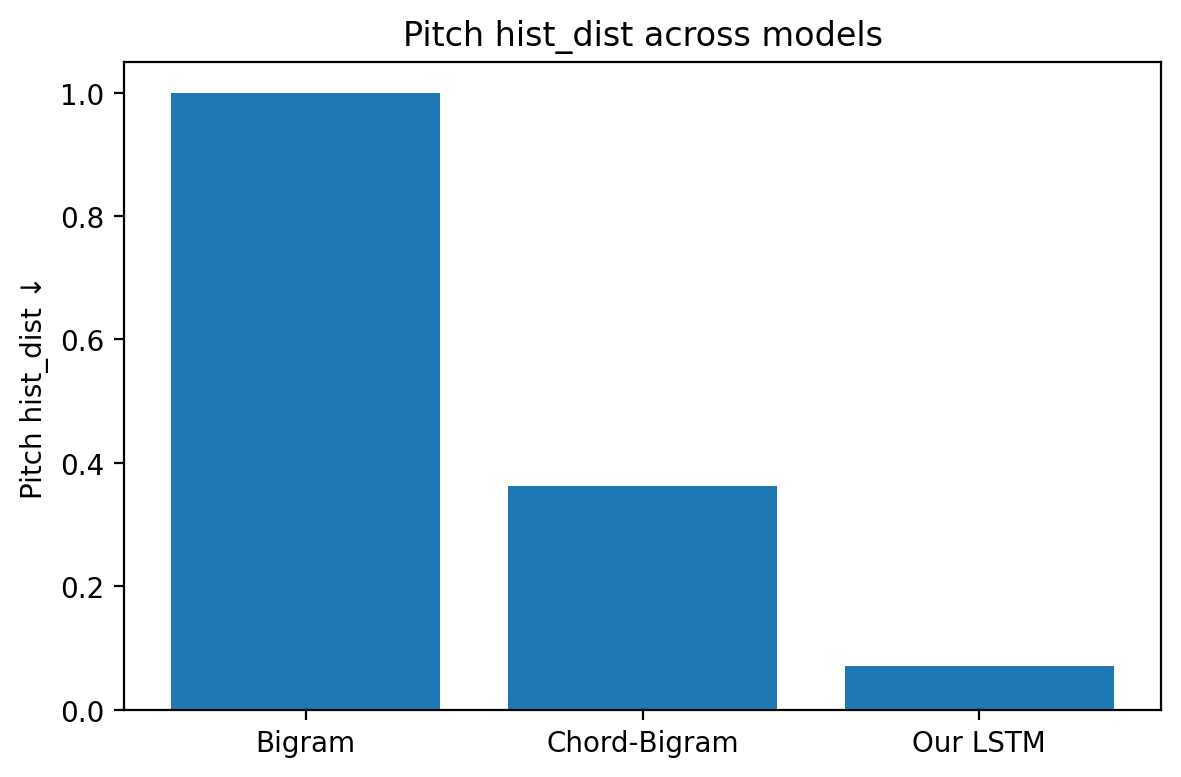

In [41]:
#BASELINE COMPARISION
import matplotlib.pyplot as plt

results_lstm = {
    "name": "Our LSTM",
    "perplexity": 3.3,
    "chord_acc": 0.13 * 100,           
    "hist_dist": 0.071,
    "int_entropy": 2.6
}

results_bi = {
    "name": "Bigram",
    "perplexity": 7.43,
    "chord_acc": 0.11746323529411765 * 100,
    "hist_dist": 1.0,
    "int_entropy": float("nan")
}

results_cbi = {
    "name": "Chord‑Bigram",
    "perplexity": 7.23,
    "chord_acc": 0.11580882352941177 * 100,
    "hist_dist": 0.3629,
    "int_entropy": 2.6362
}

models = [results_bi, results_cbi, results_lstm]
plt.figure(figsize=(6,4))
plt.bar([m["name"] for m in models],
        [m["hist_dist"] for m in models])
plt.ylabel("Pitch hist_dist ↓")
plt.title("Pitch hist_dist across models")
plt.tight_layout()
plt.show()

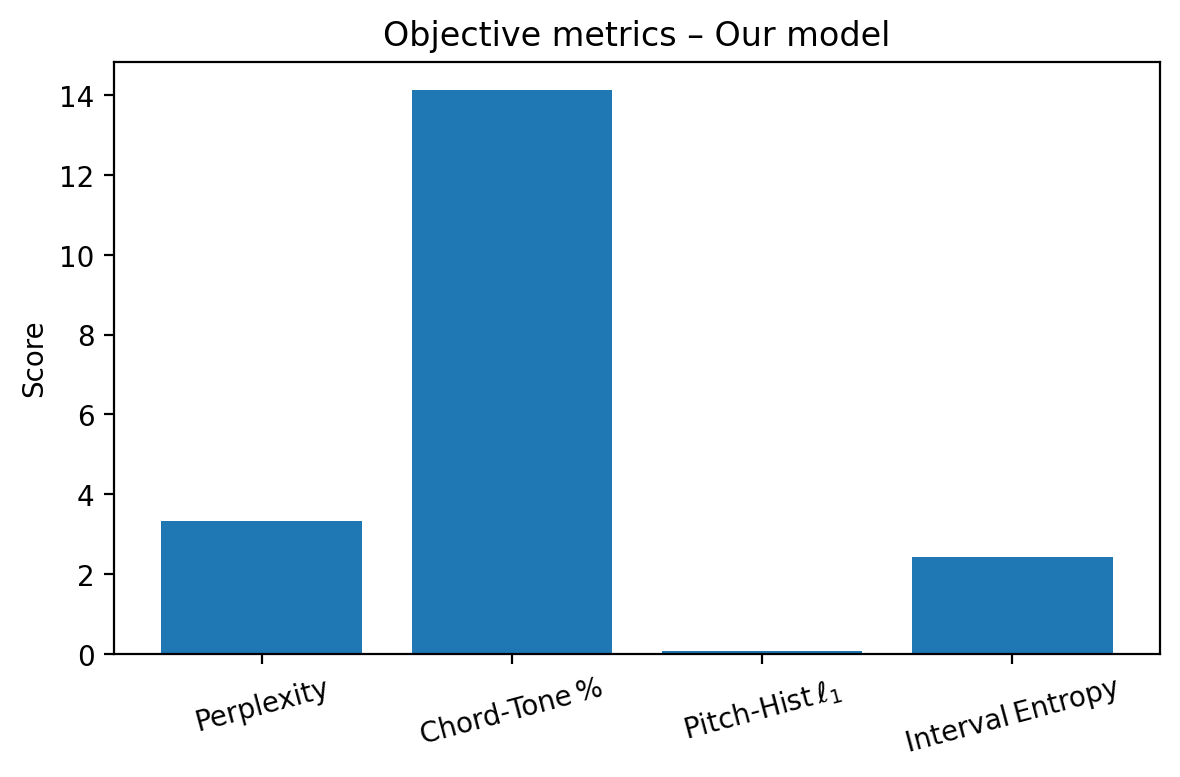

In [42]:
names  = ["Perplexity", "Chord‑Tone %", "Pitch‑Hist $\\ell_1$", "Interval Entropy"]
values = [
    results["perplexity_mean"],
    results["chord_tone_acc"] * 100,          # convert to %
    results["pitch_hist_dist"],
    results["pitch_interval_entropy"]
]

plt.figure(figsize=(6, 4))
plt.bar(names, values)
plt.ylabel("Score")
plt.title("Objective metrics – Our model")
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig("metrics_bar.png", dpi=300)
plt.show()


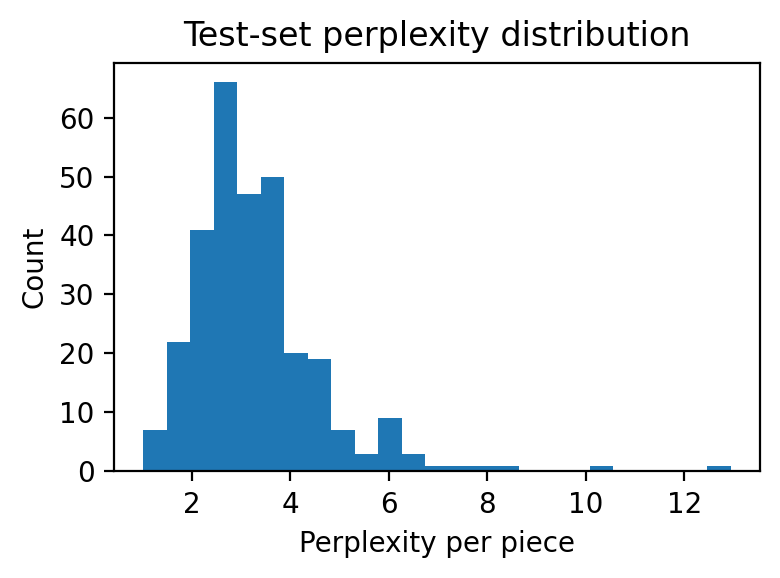

In [43]:
plt.figure(figsize=(4, 3))
plt.hist(ppl_list, bins=25)
plt.xlabel("Perplexity per piece")
plt.ylabel("Count")
plt.title("Test‑set perplexity distribution")
plt.tight_layout()
plt.savefig("ppl_hist.png", dpi=300); plt.show()

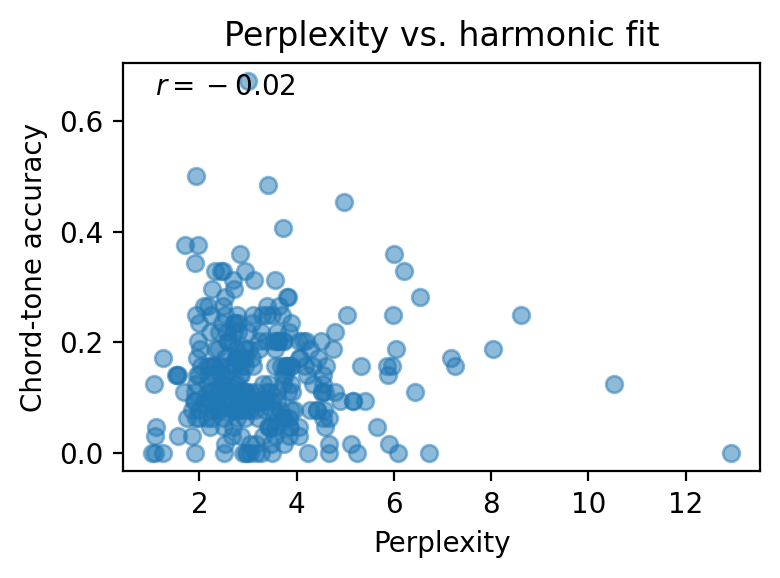

In [44]:
plt.figure(figsize=(4, 3))
plt.scatter(ppl_list, acc_list, alpha=0.5)
plt.xlabel("Perplexity")
plt.ylabel("Chord‑tone accuracy")
plt.title("Perplexity vs. harmonic fit")
# Pearson r
import scipy.stats as st
r, p = st.pearsonr(ppl_list, acc_list)
plt.annotate(f"$r={r:.2f}$", xy=(0.05, 0.92), xycoords="axes fraction")
plt.tight_layout()
plt.savefig("ppl_vs_acc.png", dpi=300); plt.show()